In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

In [116]:
DATA_PATH = '../data/games_info.csv'
df = pd.read_csv(DATA_PATH)

In [96]:
df.head()

,Title,Release date,Platform,Other platforms,Publisher,Developer,Genres,Rating,Number of players,Metascore,Number of critic reviews,User Score,Number of user reviews
0,The Legend of Zelda: Ocarina of Time,"Nov 23, 1998",Nintendo 64,NaN,Nintendo,Nintendo,"Action Adventure,Fantasy",E,1 Player,99.0,22,9.1,7359
1,Tony Hawk's Pro Skater 2,"Sep 20, 2000",PlayStation,"iPhone/iPad,PC",Activision,Neversoft Entertainment,"Sports,Alternative,Skateboarding",T,1-2,98.0,19,7.4,845
2,Grand Theft Auto IV,"Apr 29, 2008",PlayStation 3,"PC,Xbox 360",Rockstar Games,Rockstar North,"Action Adventure,Modern,Modern,Open-World",M,1 Player,98.0,64,7.8,4735
3,SoulCalibur,"Sep 8, 1999",Dreamcast,NaN,Namco,Namco,"Action,Fighting,3D",T,1-2,98.0,24,8.4,394
4,Grand Theft Auto IV,"Apr 29, 2008",Xbox 360,"PC,PlayStation 3",Rockstar Games,Rockstar North,"Action Adventure,Modern,Modern,Open-World",M,1 Player,98.0,86,8.0,3671


In [97]:
df.isnull().sum()

Title                         0
Release date                  0
Platform                      0
Other platforms             480
Publisher                     0
Developer                     1
Genres                        0
Rating                       87
Number of players           218
Metascore                     0
Number of critic reviews      0
User Score                    0
Number of user reviews        0
dtype: int64

## Tiền xử lý dữ liệu

In [117]:
df['Rating'] = df['Rating'].fillna('E')
def handle_rating(x):
    if x == 'E':
        return str(3)
    if x == 'K-A':
        return str(6)
    if x == 'E10+':
        return str(10)
    if x == 'T':
        return str(13)
    if x == 'M':
        return str(17)
    if x == 'AO':
        return str(18)

df['Rating'] = df['Rating'].astype('str').apply(lambda x: handle_rating(x)).astype(int)

In [118]:

df['Release date'] = df['Release date'].astype('str').apply(lambda x: x[-4:]).astype(int)

list_n_company = []
df['Developer'] = df['Developer'].fillna("Self Developer")
for i in range(len(df)):
    n_company = len(df['Developer'][i].split(','))
    list_n_company.append(n_company)
df['Number of companies'] = list_n_company

genres_df = df['Genres'].str.split(',', expand=True).apply(pd.value_counts, axis=1).fillna(0)
for col in genres_df:
    genres_df[col] = genres_df[col].astype(bool)

df = pd.concat([df, genres_df], axis=1, join='inner')

def handle_n_players(x):
    if x in ['Massively Multiplayer', 'Online Multiplayer']:
        return str(100)

    tokens = x.replace('+', ' ').replace('-', ' ').split()
    max_player = 1
    for token in tokens:
        if token.isdigit():
            max_player = max(max_player, int(token))
    return str(max_player)

df['Number of players'] = df['Number of players'].astype('str').apply(lambda x: handle_n_players(x)).astype(int)
df = df.drop(columns=['Genres', 'Other platforms', 'Title'])

for data in df.columns:
    if df[data].dtype=='object':
        l_en = LabelEncoder()  # converting line
        df[data] = l_en.fit_transform(df[data]) # converting line ##important

In [119]:
df['Number of players'] = df['Number of players'].fillna(df['Number of players'].mode()[0])

In [120]:
df.head(5)

,Release date,Platform,Publisher,Developer,Rating,Number of players,Metascore,Number of critic reviews,User Score,Number of user reviews,...,Tycoon,Vehicle,Vertical,Virtual,Virtual Life,Visual Novel,WWII,Wargame,Western-Style,Wrestling
0,1998,5,127,266,3,1,99.0,22,9.1,7359,...,False,False,False,False,False,False,False,False,False,False
1,2000,8,13,259,13,2,98.0,19,7.4,845,...,False,False,False,False,False,False,False,False,False,False
2,2008,10,151,329,17,1,98.0,64,7.8,4735,...,False,False,False,False,False,False,False,False,False,False
3,1999,2,121,252,13,2,98.0,24,8.4,394,...,False,False,False,False,False,False,False,False,False,False
4,2008,18,151,329,17,1,98.0,86,8.0,3671,...,False,False,False,False,False,False,False,False,False,False
5,2007,15,127,266,3,1,97.0,73,9.1,3712,...,False,False,False,False,False,False,False,False,False,False
6,2010,15,127,267,3,1,97.0,87,9.1,2887,...,False,False,False,False,False,False,False,False,False,False
7,2018,19,151,326,17,32,97.0,33,8.2,4583,...,False,False,False,False,False,False,False,False,False,False
8,2014,19,151,329,17,30,97.0,14,7.9,1716,...,False,False,False,False,False,False,False,False,False,False
9,2013,10,151,329,17,16,97.0,50,8.3,4950,...,False,False,False,False,False,False,False,False,False,False


In [134]:
def classify_userscore(x):
    if x < 8.3:
        return 0
    if x >= 8.3:
        return 1

df['User Score'] = df['User Score'].apply(lambda x: classify_userscore(x)).astype(int)

<AxesSubplot: >

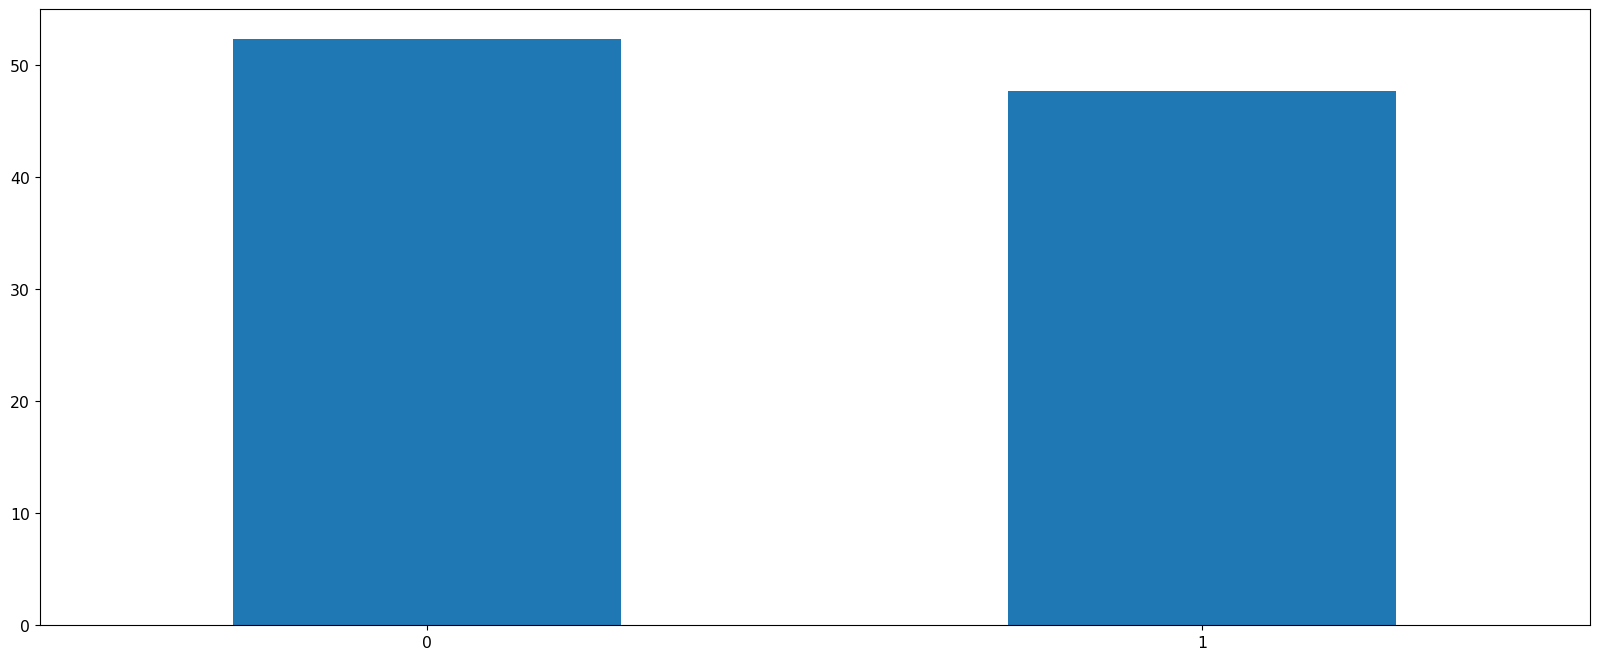

In [205]:
sr = df['User Score'].value_counts(normalize=True) * 100
sr.plot.bar(rot = 0)

In [136]:
#User score is the target so we will spilt with it
x = df.drop(['User Score'] , axis = 1).values
y= df['User Score'].values
x_train , x_test , y_train , y_test = train_test_split(x,y , test_size= 0.25 , random_state=42)

In [137]:
ro_scaler = RobustScaler()
x_train = ro_scaler.fit_transform(x_train)
x_test = ro_scaler.fit_transform(x_test)
r, c = x_train.shape
r2 ,c2 = x_test.shape
print (f"x_train = {r} and y_train = {y_train.shape} ")
print (f"x_test = {r2} and y_test = {y_test.shape} ")

x_train = 1123 and y_train = (1123,) 
x_test = 375 and y_test = (375,) 


In [194]:
def draw_cf_matrix(label, pred, title):
    cf_matrix = confusion_matrix(label, pred)

    ax = plt.subplot()

    sns.heatmap(cf_matrix, annot=True, ax = ax, fmt='g', cmap='Greens')

    ax.set_xlabel('Predicted labels')

    ax.set_ylabel('True labels')

    ax.set_title('Confusion Matrix ' + title)

    ax.xaxis.set_ticklabels([0, 1])

    ax.yaxis.set_ticklabels([0, 1])

    cf_matrix

## Mô hình hoá dữ liệu

### 1. Logistic Regression

In [138]:
lr = LogisticRegression()

In [139]:
list_C = [1, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

tuning_dict = dict(
    C = list_C,
    max_iter = [2000]
)

In [140]:
# Khởi tạo grid search cross validation
search = GridSearchCV(lr, tuning_dict, verbose=1)

# Fit grid search cross validation với tập huấn luyện
best_hp = search.fit(x_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [141]:
best_hp.best_params_

{'C': 6, 'max_iter': 2000}

In [142]:
lr_model_tuning = LogisticRegression(C = 6, max_iter=2000)
lr_model_tuning.fit(x_train , y_train)

LogisticRegression(C=6, max_iter=2000)

In [143]:
lr_model_tuning.score(x_train , y_train)

0.7577916295636687

In [144]:
lr_model_tuning.score(x_test, y_test)

0.7546666666666667

In [146]:
Y_pred = lr_model_tuning.predict(x_test)
data = pd.DataFrame({"Y_test" : y_test , "Y_pred": Y_pred})
data.head(10)

,Y_test,Y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
5,1,0
6,1,1
7,0,1
8,1,0
9,0,1


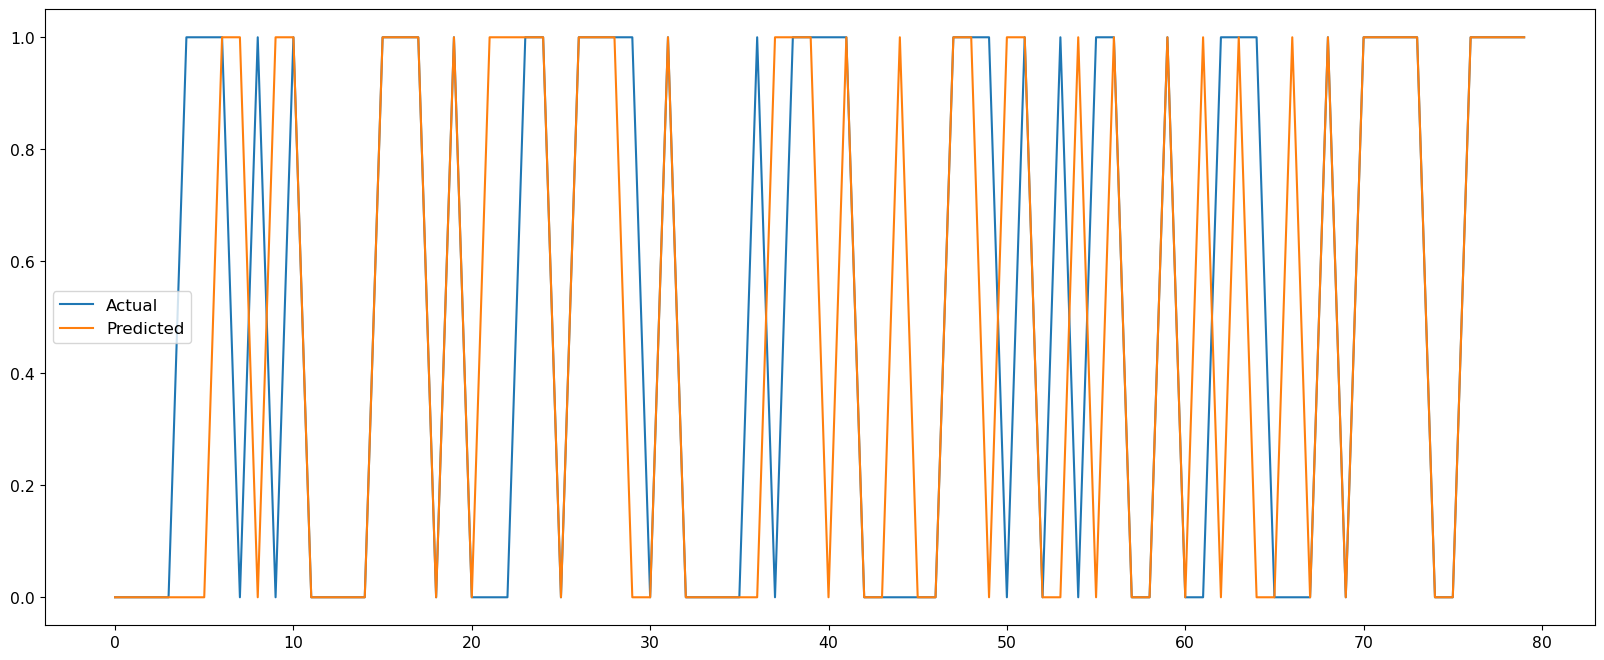

In [147]:
plt.plot(data[:80])
plt.legend(['Actual' , 'Predicted'])

### 2. K Neighbors Classifier

In [155]:
knn = KNeighborsClassifier()

In [156]:
k_range = list(range(1, 20))

tuning_dict = dict(
    n_neighbors = k_range,
)

In [157]:
# Khởi tạo grid search cross validation
search = GridSearchCV(knn, tuning_dict, verbose = 1)

# Fit grid search cross validation với tập huấn luyện
best_hp = search.fit(x_train, y_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


In [158]:
best_hp.best_params_

{'n_neighbors': 18}

In [70]:
best_hp.best_score_

0.721875

In [159]:
knn_model_tuning = KNeighborsClassifier(n_neighbors = 18)
knn_model_tuning.fit(x_train , y_train)

KNeighborsClassifier(n_neighbors=18)

In [160]:
knn_model_tuning.score(x_train , y_train)

0.7275155832591274

In [161]:
knn_model_tuning.score(x_test, y_test)

0.744

In [162]:
Y_pred = knn_model_tuning.predict(x_test)
data = pd.DataFrame({"Y_test" : y_test , "Y_pred": Y_pred})
data.head(10)

,Y_test,Y_pred
0,0,0
1,0,1
2,0,0
3,0,0
4,1,1
5,1,0
6,1,1
7,0,1
8,1,1
9,0,1


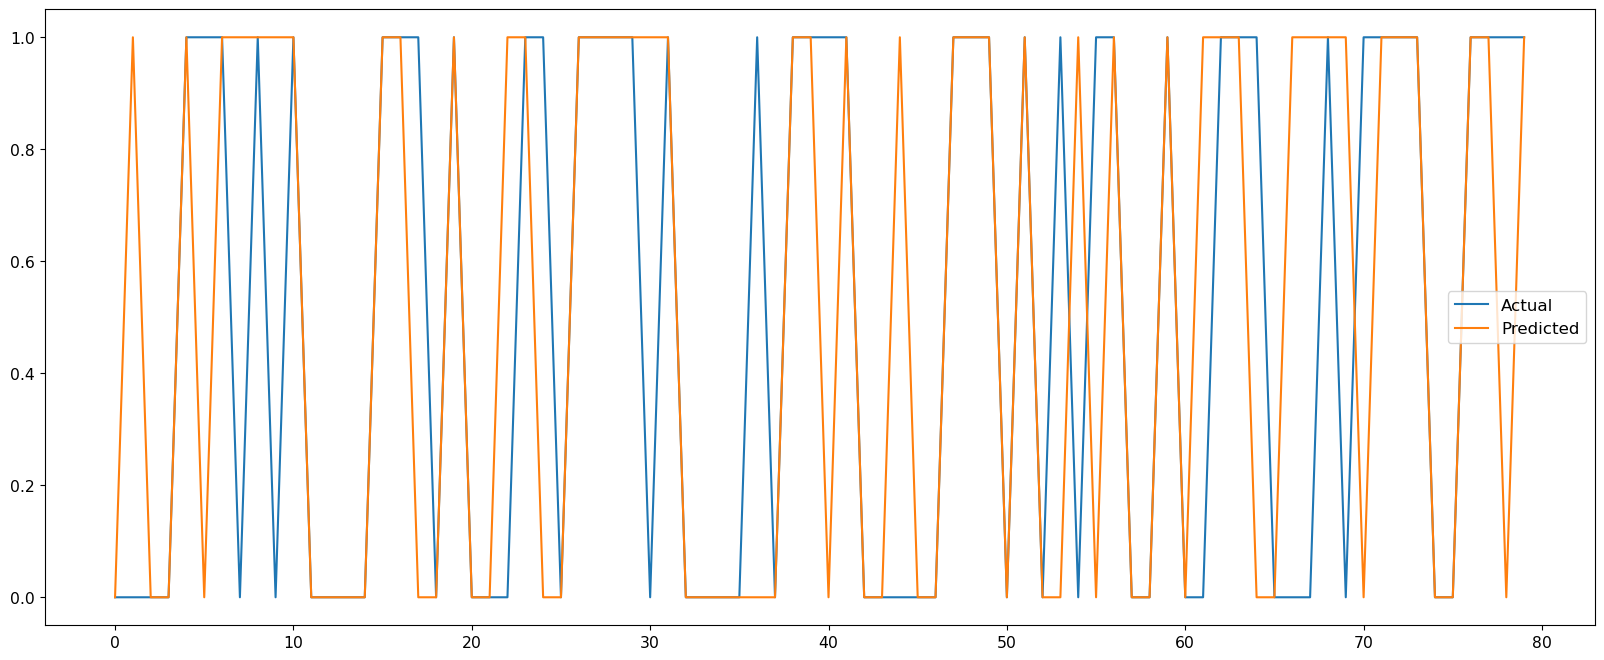

In [163]:
plt.plot(data[:80])
plt.legend(['Actual' , 'Predicted'])

### 3. Decision Tree Classifier

In [172]:
dt = DecisionTreeClassifier()

In [171]:
list_criterion = ['gini', 'entropy']

list_max_features = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

list_max_depth = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

list_min_samples_split = [2, 4, 6, 8, 10, 12, 14, 16 , 18, 20, 22, 24]

list_min_samples_leaf = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

tuning_dict = dict(
    criterion = list_criterion, 
    max_features = list_max_features,
    max_depth = list_max_depth, 
    min_samples_split = list_min_samples_split,
    min_samples_leaf = list_min_samples_leaf
)

In [173]:
# Khởi tạo grid search cross validation
search = GridSearchCV(dt, tuning_dict, verbose=1)

# Fit grid search cross validation với tập huấn luyện
best_hp = search.fit(x_train, y_train)

Fitting 5 folds for each of 29040 candidates, totalling 145200 fits


In [174]:
best_hp.best_params_

{'criterion': 'gini',
 'max_depth': 45,
 'max_features': 110,
 'min_samples_leaf': 20,
 'min_samples_split': 14}

In [175]:
dt_model_tuning = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 45,
    max_features = 110,
    min_samples_leaf = 20,
    min_samples_split = 14
)
dt_model_tuning.fit(x_train , y_train)

DecisionTreeClassifier(max_depth=45, max_features=110, min_samples_leaf=20,
                       min_samples_split=14)

In [176]:
dtt = dt_model_tuning.score(x_train , y_train)
dtt

0.780053428317008

In [177]:
dts = dt_model_tuning.score(x_test , y_test)
dts

0.744

## Đánh giá mô hình

In [188]:
y_pred_lr = lr_model_tuning.predict(x_test)
score_lr = accuracy_score(y_test, y_pred_lr)

y_pred_knn = knn_model_tuning.predict(x_test)
score_knn = accuracy_score(y_test, y_pred_knn)

y_pred_dt = dt_model_tuning.predict(x_test)
score_dt = accuracy_score(y_test, y_pred_dt)

print('Logistic Regression: ' + str(score_lr))
print('K Neighbors Classifier: ' + str(score_knn))
print('Decision Tree Classifier: ' + str(score_dt))

Logistic Regression: 0.7546666666666667
K Neighbors Classifier: 0.744
Decision Tree Classifier: 0.744


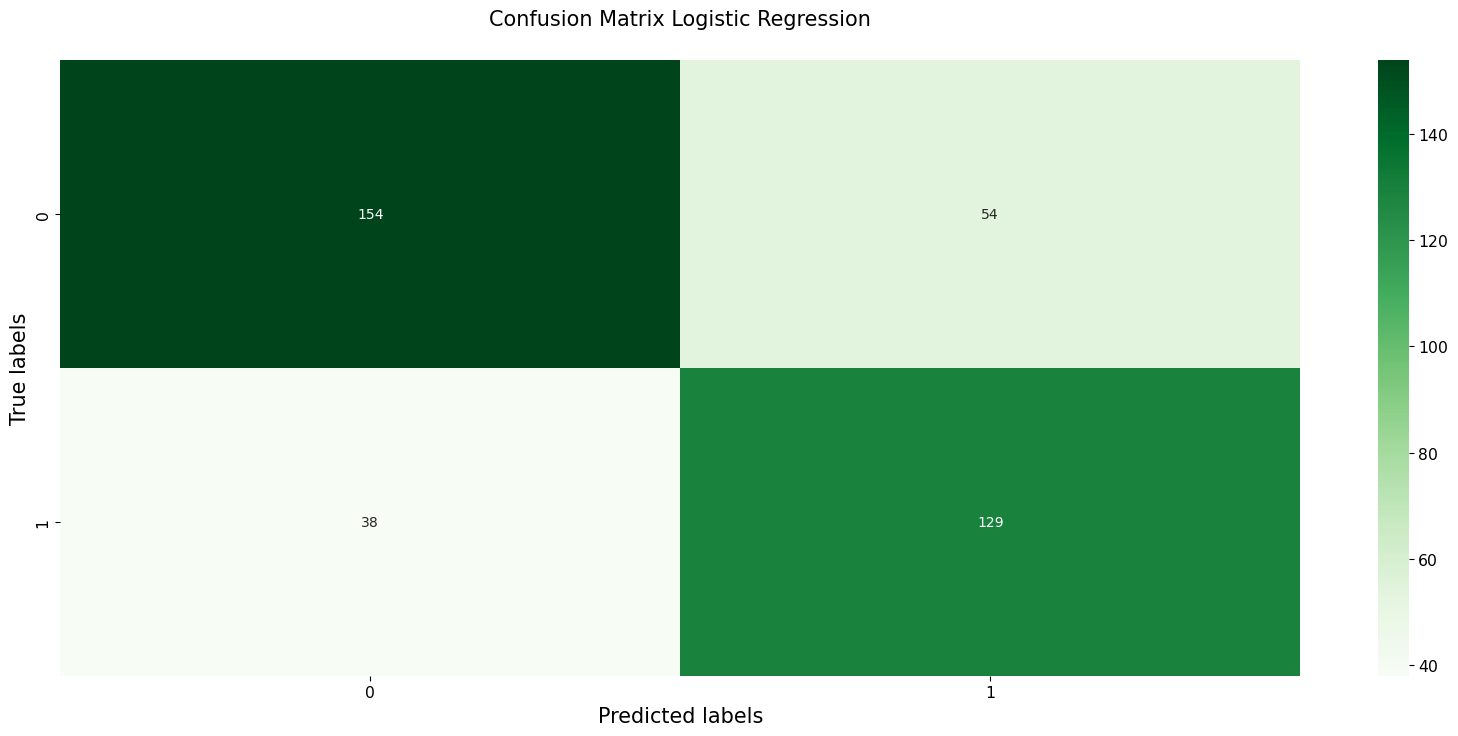

In [195]:
draw_cf_matrix(y_test, y_pred_lr, 'Logistic Regression')

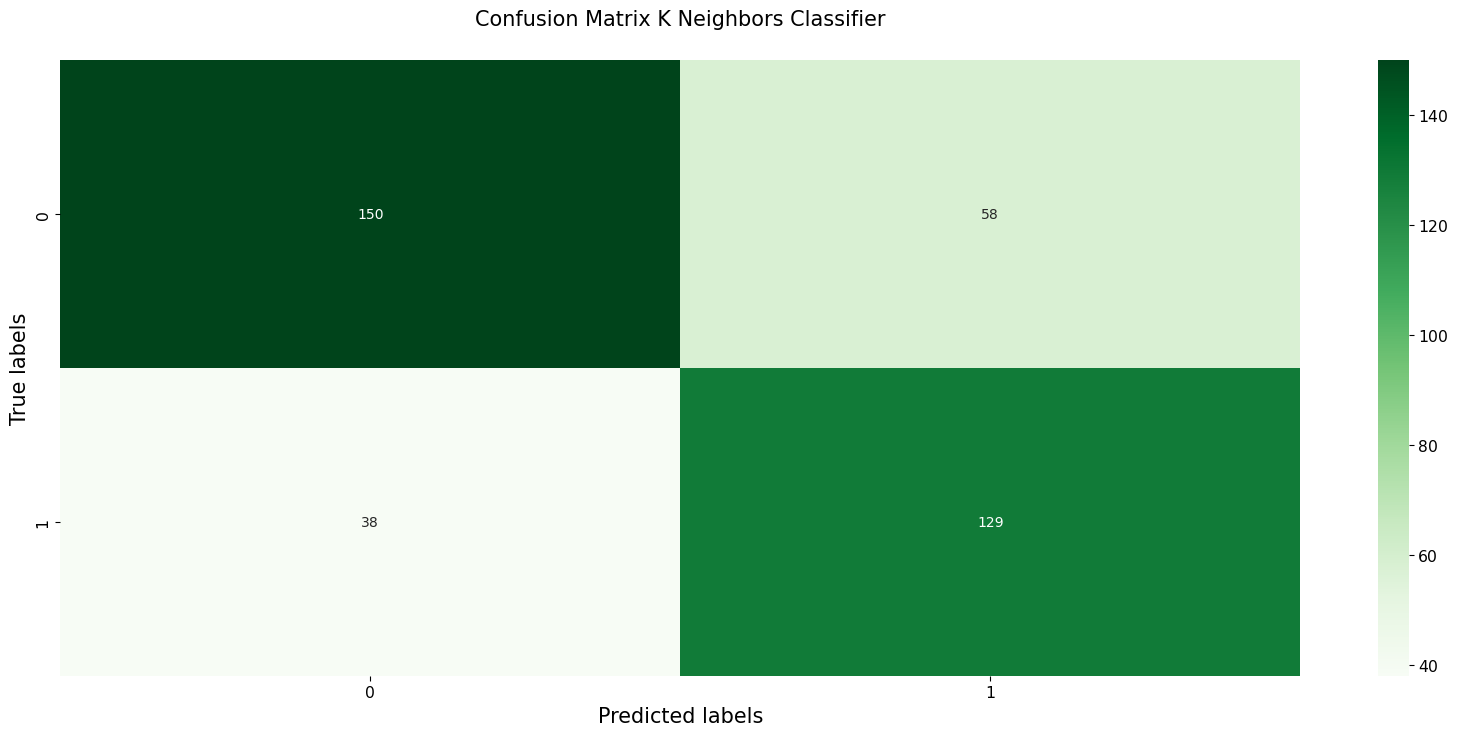

In [196]:
draw_cf_matrix(y_test, y_pred_knn, 'K Neighbors Classifier')

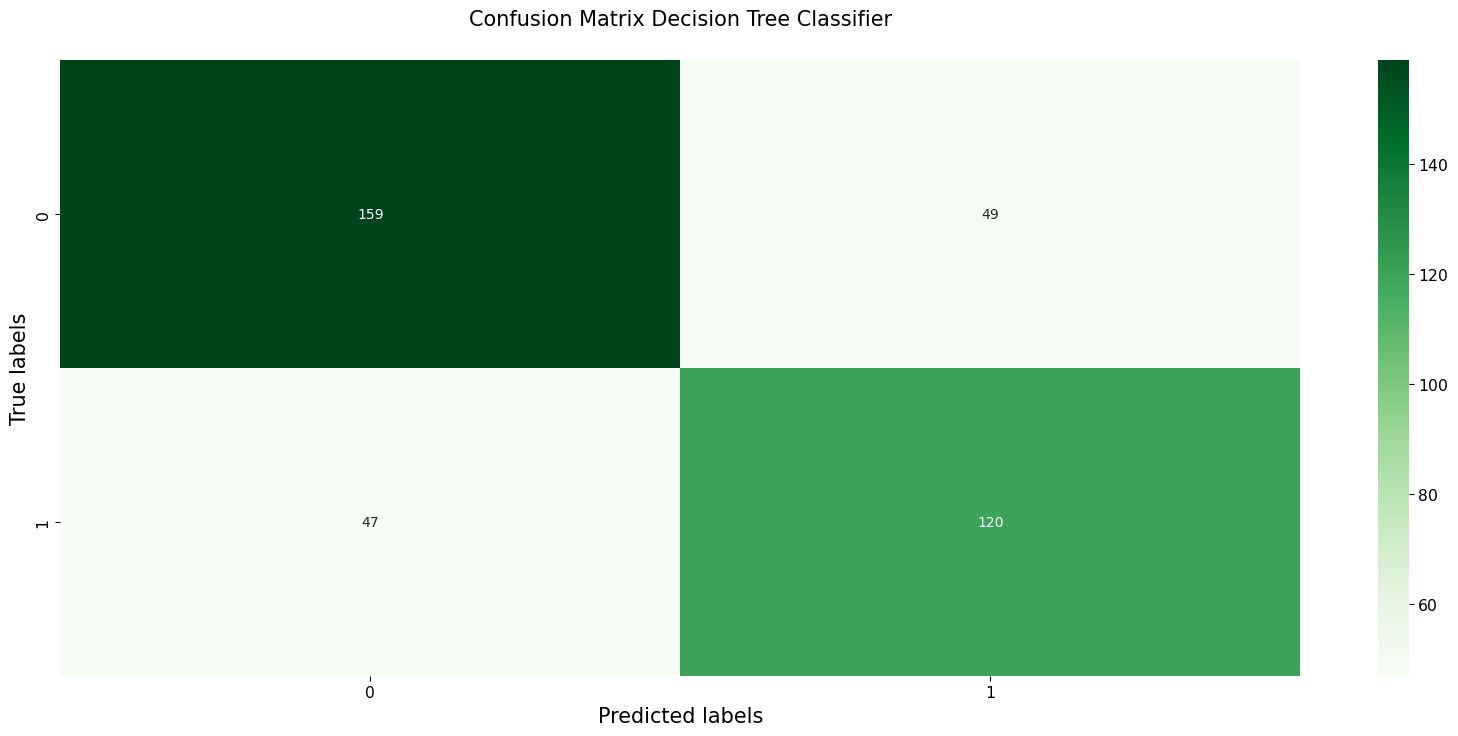

In [197]:
draw_cf_matrix(y_test, y_pred_dt, 'Decision Tree Classifier')

In [200]:
print('Logistic Regression: \n' + classification_report(y_test, y_pred_lr))

Logistic Regression: 
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       208
           1       0.70      0.77      0.74       167

    accuracy                           0.75       375
   macro avg       0.75      0.76      0.75       375
weighted avg       0.76      0.75      0.76       375



In [201]:
print('K Neighbors Classifier\n' + classification_report(y_test, y_pred_knn))

K Neighbors Classifier
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       208
           1       0.69      0.77      0.73       167

    accuracy                           0.74       375
   macro avg       0.74      0.75      0.74       375
weighted avg       0.75      0.74      0.74       375



In [202]:
print('Decision Tree Classifier\n' + classification_report(y_test, y_pred_dt))

Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       208
           1       0.71      0.72      0.71       167

    accuracy                           0.74       375
   macro avg       0.74      0.74      0.74       375
weighted avg       0.74      0.74      0.74       375

